Etraxt audio features with YAMNet (https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) and train a classifier.

Organize data for traning.

- filter the data (prob>0.8 of cough in the audio)
- split into train-validation-test
- segment cough (one audio may have more than one cough)
- save wav file to dir (easier to read in tf)
- create 3 dataframes (train-val-test)

Audio is at sr = 48kHz (da provare: dimezzare).





In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import scipy.io
from IPython.display import Image
import pathlib
import PIL
import PIL.Image
import re
from IPython import display
import pandas as pd
from scipy.io.wavfile import write
import librosa
import warnings
warnings.filterwarnings('ignore')

In [ ]:
'''
# Download coughvid data in CDF format
# Run once 
!git clone "https://github.com/virufy/virufy-cdf-coughvid.git"
'''

In [ ]:
# Load csv with metadata and filter the non-cough sounds

%cd /content/drive/MyDrive/Colab Notebooks/cough_covid_detection/virufy-cdf-coughvid

coughvid = pd.read_csv("virufy-cdf-coughvid.csv")
print(len(coughvid))
msk = (coughvid.loc[:,'cough_detected'] > 0.9)
coughvid = coughvid.loc[msk,:]
print(len(coughvid))

coughvid.head()

/content/drive/MyDrive/Colab Notebooks/cough_covid_detection/virufy-cdf-coughvid
22040
10427


,Unnamed: 0,source,patient_id,cough_detected,cough_path,age,biological_sex,reported_gender,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,pcr_test_result_inferred,covid_symptoms
4,4,coughvid,68d5215b-afdb-4b7a-81d3-fbd5677de7b4,1.0000,virufy-cdf-coughvid/68d5215b-afdb-4b7a-81d3-fb...,46.0,male,male,2020-11-26T16:21:47.764016+00:00,NaN,NaN,False,False,untested,negative,False
5,5,coughvid,3449851d-799e-404e-b143-58e852332948,0.9825,virufy-cdf-coughvid/3449851d-799e-404e-b143-58...,47.0,male,male,2020-04-14T19:39:05.755132+00:00,NaN,NaN,False,False,untested,negative,False
6,6,coughvid,0c35e382-31cd-42cb-bc87-8a84b9c52a41,1.0000,virufy-cdf-coughvid/0c35e382-31cd-42cb-bc87-8a...,27.0,female,female,2020-04-13T09:11:44.729740+00:00,NaN,NaN,False,False,positive,positive,NaN
9,9,coughvid,3ee8bfb5-a1d4-46c6-9b1c-3052af9bdedf,0.9943,virufy-cdf-coughvid/3ee8bfb5-a1d4-46c6-9b1c-30...,NaN,NaN,NaN,2020-04-12T20:09:17.098213+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN
12,12,coughvid,cdd18865-400a-448e-902b-c8b53644a1c8,0.9881,virufy-cdf-coughvid/cdd18865-400a-448e-902b-c8...,24.0,male,male,2020-11-28T20:14:22.235183+00:00,NaN,NaN,False,False,untested,negative,False


In [ ]:
# Disclaimer: some of these pcr_test_result labels have been inferred based on other columns
# (https://github.com/virufy/virufy-cdf-coughvid)
# Target = pcr_test_result_inferred
# Positive, negative, untested

# coughvid['pcr_test_result_inferred'].head(30)

In [ ]:
# Filter out untested results

msk = (coughvid.loc[:,'pcr_test_result_inferred'] =='untested')
coughvid = coughvid.loc[~msk,:]
print(len(coughvid))

assert len(coughvid) == 6238
coughvid.head(5)

6238


,Unnamed: 0,source,patient_id,cough_detected,cough_path,age,biological_sex,reported_gender,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,pcr_test_result_inferred,covid_symptoms
4,4,coughvid,68d5215b-afdb-4b7a-81d3-fbd5677de7b4,1.0000,virufy-cdf-coughvid/68d5215b-afdb-4b7a-81d3-fb...,46.0,male,male,2020-11-26T16:21:47.764016+00:00,NaN,NaN,False,False,untested,negative,False
5,5,coughvid,3449851d-799e-404e-b143-58e852332948,0.9825,virufy-cdf-coughvid/3449851d-799e-404e-b143-58...,47.0,male,male,2020-04-14T19:39:05.755132+00:00,NaN,NaN,False,False,untested,negative,False
6,6,coughvid,0c35e382-31cd-42cb-bc87-8a84b9c52a41,1.0000,virufy-cdf-coughvid/0c35e382-31cd-42cb-bc87-8a...,27.0,female,female,2020-04-13T09:11:44.729740+00:00,NaN,NaN,False,False,positive,positive,NaN
12,12,coughvid,cdd18865-400a-448e-902b-c8b53644a1c8,0.9881,virufy-cdf-coughvid/cdd18865-400a-448e-902b-c8...,24.0,male,male,2020-11-28T20:14:22.235183+00:00,NaN,NaN,False,False,untested,negative,False
14,14,coughvid,0e35f667-974e-4ffc-b596-1b9a94793d1b,0.9658,virufy-cdf-coughvid/0e35f667-974e-4ffc-b596-1b...,18.0,male,male,2020-04-14T10:52:04.775637+00:00,NaN,NaN,False,False,untested,negative,False


In [ ]:
# Check wheter the dataset is imbalanced
coughvid['pcr_test_result_inferred'].value_counts()

negative    5675
positive     563
Name: pcr_test_result_inferred, dtype: int64

In [ ]:
# Create a new column (target) containing the labels as numbers 
# (usefull in training)
my_classes = ['positive', 'negative']
map_class_to_id = {'negative':0, 'positive':1}

class_id = coughvid['pcr_test_result_inferred'].apply(lambda name: map_class_to_id[name])
coughvid = coughvid.assign(target=class_id)

In [ ]:
from sklearn.model_selection import train_test_split

# Train-val-test split
stratify_labels = coughvid["pcr_test_result_inferred"].map(
    lambda x: x if x is "positive" else "untested")

cdf_train_val, cdf_test = train_test_split(
    coughvid, test_size=0.2, random_state = 0, stratify = stratify_labels)

stratify_labels2 = cdf_train_val["pcr_test_result_inferred"].map(
    lambda x: x if x is "positive" else "untested")

cdf_train, cdf_val = train_test_split(
    cdf_train_val, test_size=0.2, random_state = 0, stratify = stratify_labels2)


cdf_train.shape, cdf_val.shape, cdf_test.shape

((3992, 17), (998, 17), (1248, 17))

In [ ]:
def partition_info(df):

  listname = df['pcr_test_result_inferred']
  negative_num = np.zeros(1)
  pos_num = np.zeros(1)

  for name in listname:
    if name == 'negative':
      negative_num = negative_num + 1
    elif name == 'positive':
      pos_num = pos_num + 1


  print('Negative cases = ',negative_num)
  print('Positive cases =',pos_num)
  print('P/N = ', pos_num/negative_num, '\n\n')

print('Train')
partition_info(cdf_train)
print('Val')
partition_info(cdf_val)
print('Test')
partition_info(cdf_test)

Train
Negative cases =  [3633.]
Positive cases = [359.]
P/N =  [0.09881641] 


Val
Negative cases =  [903.]
Positive cases = [95.]
P/N =  [0.10520487] 


Test
Negative cases =  [1139.]
Positive cases = [109.]
P/N =  [0.09569798] 




In [ ]:
# Segmentation script (https://c4science.ch/diffusion/10770/)
# Data durantion in s 
def segment_cough(x,fs, cough_padding=0.2, min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

def compute_SNR(x, fs):
    """Compute the Signal-to-Noise ratio of the audio signal x (np.array) with sampling frequency fs (float)"""
    segments, cough_mask = segment_cough(x,fs)
    RMS_signal = 0 if len(x[cough_mask])==0 else np.sqrt(np.mean(np.square(x[cough_mask])))
    RMS_noise = np.sqrt(np.mean(np.square(x[~cough_mask])))
    SNR = 0 if (RMS_signal==0 or np.isnan(RMS_noise)) else 20*np.log10(RMS_signal/RMS_noise)
    return SNR

In [ ]:
# ELIMINATE COUGH SEGMENTS > 0.96s

def prepare_data(df, save_dir):
  # Read and segment audio in single coughs
  # Save to save_dir and create new_dataframe that consider each single cough
  my_rows = []
  len_audio = []

  for row in df.itertuples(index=False, name=None):
    
    path_to_audio = row[4]
    path, name_file = os.path.split(path_to_audio)
    audio_name, ext = os.path.splitext(name_file) 

    # Load and segment
    x, fs = librosa.load(path_to_audio, sr=None)
    cough_segments, cough_mask = segment_cough(x, fs)

    '''
    print(cough_segments)
    print(np.max(cough_segments[0]))
    print(np.min(cough_segments[0]))
    '''
    # cough_segments = np.array(cough_segments, dtype=np.int16)
    # print(cough_segments.dtype)
    number_cough = len(cough_segments)


    if number_cough != 0:
      for i in range(number_cough):
        # Replace path to audio, convert to wav and save to new dir
        segment_duration = len(cough_segments[i]) / fs
        if segment_duration <= 0.96:
          savepath = os.path.join(save_dir, audio_name + '_' + str(i) + '.wav')
          write(filename=savepath, rate=fs, data=np.array(cough_segments[i]* 32767, dtype=np.int16))
          '''
          print(np.max(np.array(cough_segments[i]* 32767, dtype=np.int16)))
          pr'int(np.min(np.array(cough_segments[i]* 32767, dtype=np.int16)))
          '''
          mod_row = list(row)
          mod_row[4] = savepath
              
          my_rows.append(mod_row)
          len_audio.append(segment_duration)

        
  new_dataframe = pd.DataFrame(my_rows, columns = list(df.columns))

  return new_dataframe, len_audio

In [ ]:
base_dir = 'segmented_wav_audio_4_max096'

save_dir_train = os.path.join(base_dir, 'Train_seg_09')
save_dir_val = os.path.join(base_dir,'Val_seg_09')
save_dir_test = os.path.join(base_dir,'Test_seg_09')


os.mkdir(base_dir)
os.mkdir(save_dir_train)
os.mkdir(save_dir_val)
os.mkdir(save_dir_test)

In [ ]:
new_train_df, len_train= prepare_data(cdf_train, save_dir_train)
new_train_df.to_csv(os.path.join(base_dir,'Train_seg_09_data.csv'))

In [ ]:
new_val_df, len_val = prepare_data(cdf_val, save_dir_val)
new_val_df.to_csv(os.path.join(base_dir,'Val_seg_09_data.csv'))

In [ ]:
new_test_df, len_test = prepare_data(cdf_test, save_dir_test)
new_test_df.to_csv(os.path.join(base_dir,'Test_seg_09_data.csv'))

In [ ]:
'''
import pickle 

with open(os.path.join(base_dir,"len_audio_train_09_seg.txt"), "wb") as fp:
  pickle.dump(len_train, fp)

with open(os.path.join(base_dir,"len_audio_val_09_seg.txt"), "wb") as fp:
  pickle.dump(len_val, fp)

with open(os.path.join(base_dir,"len_audio_train_09_seg.txt"), "wb") as fp:
  pickle.dump(len_test, fp)
'''

In [ ]:
'''
import pickle 


with open(os.path.join(base_dir,"len_audio_train_09_seg.txt"), "rb") as fp:
   len_train = pickle.load(fp)

with open(os.path.join(base_dir,"len_audio_val_09_seg.txt"), "rb") as fp:
  len_val = pickle.load(fp)

with open(os.path.join(base_dir,"len_audio_train_09_seg.txt"), "rb") as fp:
  len_test = pickle.load(fp)
'''

Train
number of examples =  9610
mean = 0.7105308814602844
std = 0.07952199706369657
mean - std = 0.6310088843965879
mean + std = 0.790052878523981 

Val
number of examples =  2418
mean = 0.712307407981803
std = 0.07917461809446043
mean - std = 0.6331327898873426
mean + std = 0.7914820260762635 

Test
number of examples =  2945
mean = 0.7108983022071309
std = 0.08155369591284839
mean - std = 0.6293446062942825
mean + std = 0.7924519981199794 



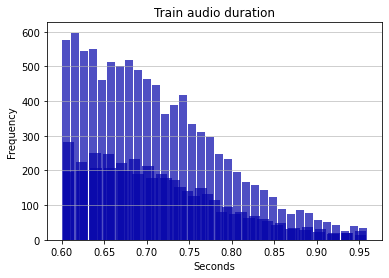

In [ ]:
def audio_len(len_audio):
  
  mean_audio = np.mean(len_audio)
  std_a = np.std(len_audio)
  n, bins, patches = plt.hist(x=len_audio, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
  
  plt.grid(axis='y', alpha=0.75)
  plt.xlabel('Seconds')
  plt.ylabel('Frequency')
  plt.title('Train audio duration')
  

  print('number of examples = ', len(len_audio))
  print('mean =', mean_audio)
  print('std =', std_a)
  print('mean - std =', mean_audio - std_a)
  print('mean + std =', mean_audio + std_a, '\n')


print('Train')
audio_len(len_train)  # 4617 --> 11688

print('Val')
audio_len(len_val)    # 1155 --> 2874

print('Test')
audio_len(len_test)   # 1444 --> 3627


In [ ]:
# OLD

def partition_info(df):
  # Get info on number of positive and negative cases
  listname = df['pcr_test_result_inferred']
  negative_num = np.zeros(1)
  pos_num = np.zeros(1)

  for name in listname:
    if name == 'negative':
      negative_num = negative_num + 1
    elif name == 'positive':
      pos_num = pos_num + 1


  print('Negative cases = ',negative_num)
  print('Positive cases =',pos_num)
  print('P/N = ', pos_num/negative_num, '\n')
  
  return negative_num, pos_num

print('Train')
neg, pos = partition_info(cdf_train)
print('Val')
partition_info(cdf_val)
print('Test')
partition_info(cdf_test)

Train
Negative cases =  [3633.]
Positive cases = [359.]
P/N =  [0.09881641] 

Val
Negative cases =  [903.]
Positive cases = [95.]
P/N =  [0.10520487] 

Test
Negative cases =  [1139.]
Positive cases = [109.]
P/N =  [0.09569798] 



(array([1139.]), array([109.]))

In [ ]:
# NEW

print('Train')
neg, pos = partition_info(new_train_df)
print('Val')
partition_info(new_val_df)
print('Test')
partition_info(new_test_df)

Train
Negative cases =  [8767.]
Positive cases = [843.]
P/N =  [0.09615604] 

Val
Negative cases =  [2174.]
Positive cases = [244.]
P/N =  [0.11223551] 

Test
Negative cases =  [2692.]
Positive cases = [253.]
P/N =  [0.09398217] 



(array([2692.]), array([253.]))